#### IMPORTING REQUIRED LIBRARIES

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import shutil
import cv2
from keras.models import Sequential , Model , load_model
from keras.optimizers import Adam
from keras.layers import *
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input , decode_predictions
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report ,accuracy_score , confusion_matrix
from sklearn.preprocessing import LabelEncoder , LabelBinarizer , OneHotEncoder
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

In [30]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = []
labels = []

path = '/content/drive/MyDrive/Face-Mask-Detection-master/dataset'
#path = './dataset'
categories = os.listdir(path)
print(categories)

['without_mask', 'with_mask']


#### DATA PRE-PROCESSING

In [3]:
for category in categories:
    directory = os.path.join(path , category)

    print(f'{category.upper()} - ',  len(os.listdir(directory)))
    for i in os.listdir(directory):
        img_path = os.path.join(directory , i)
        img = image.load_img(img_path , target_size = (224 , 224))
        img = image.img_to_array(img)
        img = preprocess_input(img)

        data.append(img)
        labels.append(category)

WITHOUT_MASK -  1918
WITH_MASK -  1915


C:\Users\HP\anaconda3\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


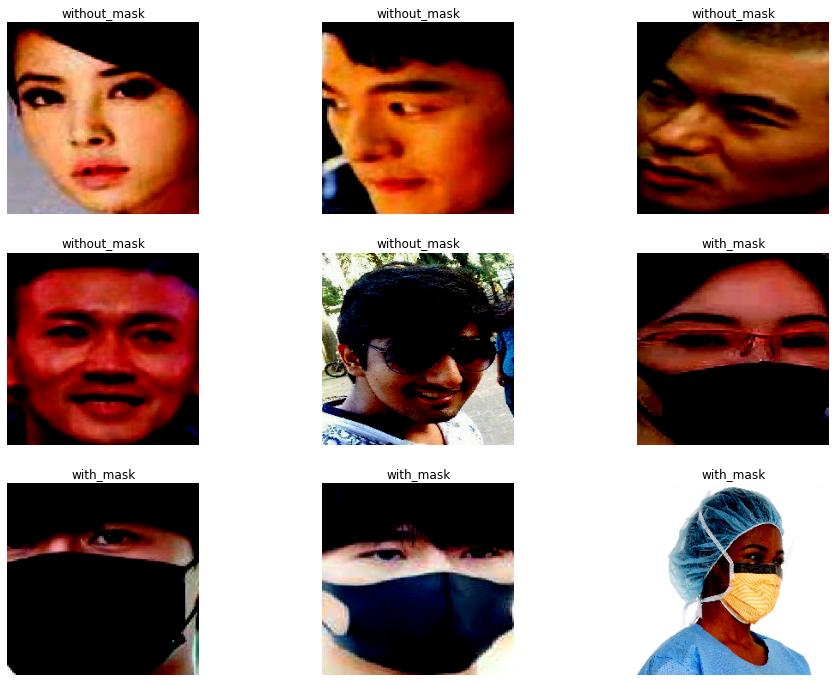

In [31]:
plt.figure(figsize = (16 , 12))
for idx , (img , label) in enumerate(list(zip(data , labels))[50:3500:400]):
    plt.subplot(3 , 3 , idx+1)
    plt.imshow(img)
    plt.axis(False)
    plt.title(label)
    
plt.show()    

In [74]:
len(data) , len(labels)

(3833, 3833)

In [75]:
le = LabelEncoder()
labels = le.fit_transform(labels)
np.unique(labels , return_counts = True)

(array([0, 1], dtype=int64), array([1915, 1918], dtype=int64))

In [76]:
labels = to_categorical(labels)
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [77]:
x_train , x_test , y_train , y_test = train_test_split(np.asarray(data) , labels , test_size = 0.1 , shuffle = True , random_state = 42 , stratify = labels)

In [78]:
x_train.shape , y_train.shape , x_test.shape , y_test.shape

((3449, 224, 224, 3), (3449, 2), (384, 224, 224, 3), (384, 2))

#### DATA AUGMENTATION

In [50]:
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2, 
                  shear_range=0.15, horizontal_flip=True, brightness_range = (0 , 0.5))

In [51]:
train_datagen = datagen.flow_from_directory(path)

Found 3833 images belonging to 2 classes.


In [52]:
train_datagen.class_indices

{'with_mask': 0, 'without_mask': 1}

In [54]:
label2class = {v:k for k , v in train_datagen.class_indices.items()}
label2class

{0: 'with_mask', 1: 'without_mask'}

#### MODEL ARCHITECTURE

In [31]:
baseModel = MobileNetV2(weights = 'imagenet', include_top = False , input_shape = (224, 224, 3))
baseModel.output

<KerasTensor: shape=(None, 7, 7, 1280) dtype=float32 (created by layer 'out_relu')>

In [32]:
x = baseModel.output
x = GlobalAveragePooling2D()(x)
x = Dense(128 , activation='relu')(x)
x = Dropout(0.4)(x)

predictions = Dense(2 , activation='softmax')(x)

model = Model(inputs = baseModel.input , outputs = predictions)

for layer in baseModel.layers:
    layer.trainable = False

model.summary()

In [ ]:
plot_model(model , to_file='/content/drive/MyDrive/Face-Mask-Detection-master/model.png' , show_shapes=True)

In [33]:
INIT_LR = 1e-4
EPOCHS = 20
BATCH = 32

In [34]:
optim = Adam(learning_rate = INIT_LR , decay=INIT_LR / EPOCHS)
model.compile(loss = "binary_crossentropy" , optimizer = optim , metrics = ["accuracy"])
print('Model Compiled')

Model Compiled


#### MODEL TRAINING

In [ ]:
hist = model.fit(x=x_train, y=y_train, batch_size=BATCH, epochs=EPOCHS, steps_per_epoch=len(x_train)//BATCH, validation_data=(x_test , y_test), validation_steps=len(x_test)//BATCH)

In [ ]:
#hist = model.fit(train_datagen, batch_size=BATCH, epochs=EPOCHS)

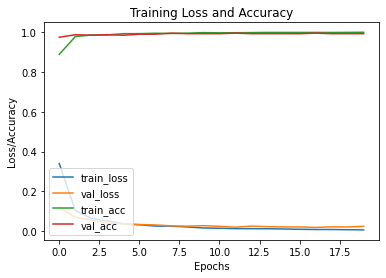

In [36]:
N = EPOCHS

plt.figure()
plt.plot(np.arange(0, N), hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), hist.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), hist.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

#### SAVE THE MODEL

In [38]:
model.save_weights('#model_weights.h5')

In [41]:
model.save('#model.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [42]:
# serialize model to JSON
model_json = model.to_json()
with open("#model.json", "w") as json_file:
    json_file.write(model_json)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#### MAKING PREDICTIONS AND INFERENCE

In [86]:
model = load_model('#model.h5')

In [44]:
preds = model.predict(x_test)    # (384, 2)
preds[:5]

array([[1.00000000e+00, 4.96690362e-11],
       [1.00000000e+00, 2.69928108e-10],
       [1.00000000e+00, 1.29824727e-11],
       [1.09836334e-10, 1.00000000e+00],
       [1.82860518e-08, 1.00000000e+00]], dtype=float32)

In [46]:
preds = np.argmax(preds , axis = 1)
preds.shape

(384,)

In [48]:
le.classes_

array(['with_mask', 'without_mask'], dtype='<U12')

In [49]:
print(classification_report(y_test.argmax(axis = 1) , preds , target_names = le.classes_))

              precision    recall  f1-score   support

   with_mask       0.98      1.00      0.99       192
without_mask       1.00      0.98      0.99       192

    accuracy                           0.99       384
   macro avg       0.99      0.99      0.99       384
weighted avg       0.99      0.99      0.99       384



([<matplotlib.axis.YTick at 0x7f0253def510>,
 [Text(0, 0.5, 'with_mask'), Text(0, 1.5, 'without_mask')])

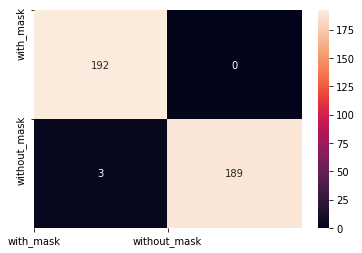

In [66]:
cm = confusion_matrix(y_test.argmax(axis=1).reshape(-1 , 1) , preds.reshape(-1 , 1))
sns.heatmap(cm , annot = True , fmt = 'd')
plt.xticks(ticks=[0,1] , labels=list(le.classes_))
plt.yticks(ticks=[0,1] , labels=list(le.classes_))

In [85]:
acc = accuracy_score(y_test.argmax(axis = 1) , preds)*100
print('Accuracy' , acc)

Accuracy 99.73958333333334


#### TEST ON CUSTOM IMAGES

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


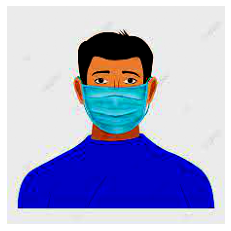

Prediction:  with_mask


In [93]:
plt.figure()

img = image.load_img('mask.jpg' , target_size = (224, 224))
img = image.img_to_array(img)
img = np.expand_dims(img , axis = 0)
img = preprocess_input(img)

plt.imshow(img.reshape((img.shape[1:])))
plt.axis(False)
plt.show()

print('Prediction: ' , label2class[model.predict(img)[0].argmax()])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


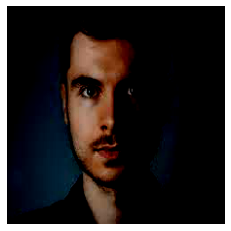

Prediction:  without_mask


In [94]:
plt.figure()

img = image.load_img('nomask.jpg' , target_size = (224, 224))
img = image.img_to_array(img)
img = np.expand_dims(img , axis = 0)
img = preprocess_input(img)

plt.imshow(img.reshape((img.shape[1:])))
plt.axis(False)
plt.show()

print('Prediction: ' , label2class[model.predict(img)[0].argmax()])

### VIDEO

In [ ]:
"""
cap = cv2.VideoCapture(0)
cnt = 1

while True:
    ret , frame = cap.read()
    if ret == False:
        break
    cv2.imwrite(f'./static/image_{cnt}.jpg' , frame)
    path = f'./static/image_{cnt}.jpg'
    img = image.load_img(path , target_size = (224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(frame , axis = 0)
    img = preprocess_input(img)
    label = label2class[model.predict(img)[0].argmax()]
    
    cv2.putText(frame , label , (50, 50) , cv2.FONT_HERSHEY_SIMPLEX , 2 , (255,0,0) , 2)
    cv2.imshow('label' , frame)
    cnt += 1
    
    if cv2.waitKey(1) == 13:
        break

cap.release()
cv2.destroyAllWindows()

"""

In [96]:
cap.release()
cv2.destroyAllWindows()